# Fleet assignment problem

In [481]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

## Problem description

Given a set of flights to be flown, an airline company needs to determine the specific route flown by each airplane in the most cost-effective way. Clearly, the airline company should try to use as fewer airplanes as possible, but the same airplane can operate two subsequent flights only if the time interval between the arrival of the first flight and the departure of the next flight is longer than or equal to one hour.

The task of the airline operations team is to determine the minimum number of airplanes needed to operate the given list of flights. This problem is known as the **fleet assignment problem** or **aircraft rotation problem**.

### Generate Flight Data

In [546]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt
from numpy.random import RandomState

# python generator to create departure and arrival times from single airport
def generate_flights(N_flights=30, min_duration=1, max_duration=4, max_departure=24, seed=0):
    rs = RandomState(seed)
    for flight in range(N_flights):
        end_flight = max_departure + 1
        while end_flight > max_departure:
            start_flight = np.floor(max_departure * rs.rand())
            end_flight = start_flight + 3 * np.ceil((max_duration + 1 - min_duration) * rs.rand()) 
        yield flight + 1, int(start_flight), int(end_flight)

# generate flight data
FlightData = pd.DataFrame([[flight, departure, arrival] for flight, departure, arrival in generate_flights()])
FlightData.columns = ["Flight", "Departure", "Arrival"]
FlightData.set_index("Flight", inplace=True)
FlightData.head()

,Departure,Arrival
Flight,,
1,13,22
2,14,23
3,10,19
4,10,22
5,1,4


### Visualize Flight Data

<AxesSubplot:title={'center':'FlightData'}, xlabel='Departure/Arrival Time'>

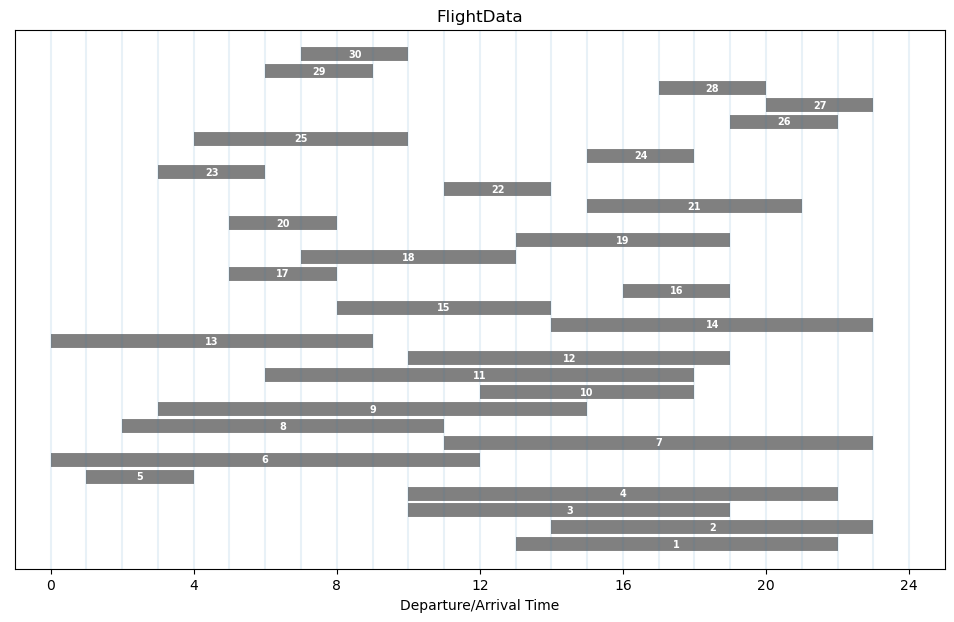

In [682]:
# visualize flight data
def draw_flights(FlightData):
    bar_style = {'alpha':1.0, 'lw':10, 'solid_capstyle':'butt'}
    text_style = {'fontsize': 7, 'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111, xlabel="Departure/Arrival Time", title="FlightData")
    ax.get_yaxis().set_visible(False)
    for flight, row in FlightData.iterrows():
        departure, arrival = row
        ax.plot([departure, arrival], [flight]*2, 'gray', **bar_style)
        ax.text((departure + arrival)/2, flight, flight, **text_style)
    for hr in range(25):
        ax.axvline(hr, alpha=0.1)
    ax.set_xlim(-1, 25)
    ax.set_xticks([4*i for i in range(7)])
    return ax

draw_flights(FlightData)

## Pyomo Model

The fleet assignment problem can be formulated and solved as an MILP. The idea of the MILP formulation is to construct a feasible path in a directed graph where the flights are nodes with indices $\mathcal{F} = \left\{ 1, \ldots, F \right\}$. The set of arcs $\mathcal{A} \subseteq \mathcal{F} \times \mathcal{F}$ that can be used by each aircraft is then:

$$
\mathcal{A} = \{ a = (f_1, f_2): f_1 \text{ arrives at least 1h before the departure of } f_2, \ f_1, f_2 \in \mathcal{F} \}
$$

The following cell finds the set of arcs that can be used. These arcs are displayed in a graph of the flight data. Arcs corresponding to the minimum time between arrival and departure are highlighted.

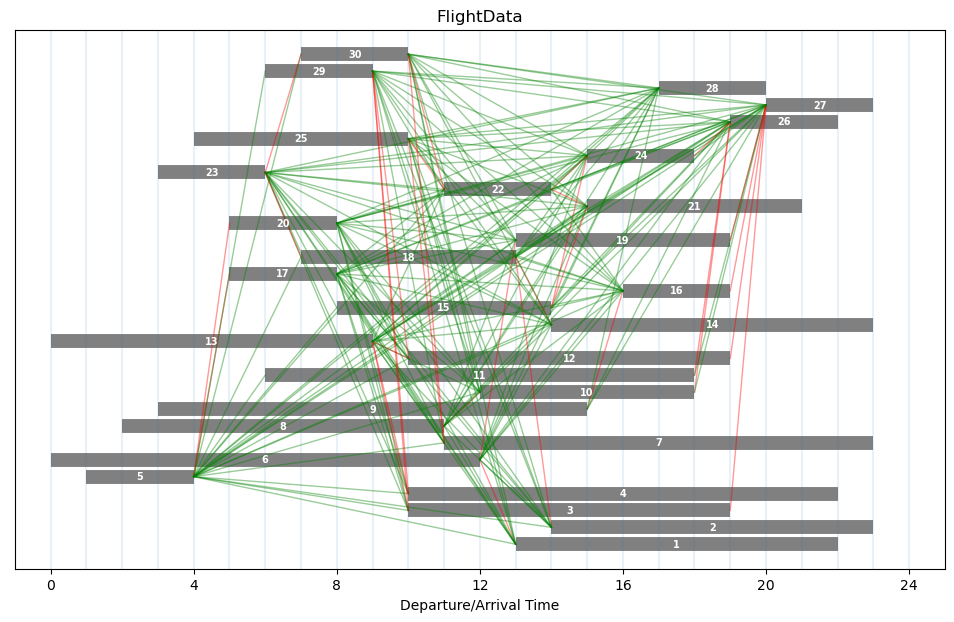

In [683]:
min_time = 1

# create an iterator to produce pairs of flight numbers
flight_pairs = list(filter(
    lambda pair: FlightData.loc[pair[0], "Arrival"] + min_time <= FlightData.loc[pair[1], "Departure"],
    [[i, j] for i in FlightData.index for j in FlightData.index if i != j]
))

ax = draw_flights(FlightData)
for flight1, flight2 in flight_pairs:
    arr = FlightData.loc[flight1, "Arrival"]
    dep = FlightData.loc[flight2, "Departure"]
    c = 'r' if dep - arr <= min_time else 'g'
    ax.plot([arr, dep], [flight1, flight2], color=c, lw=1, alpha=0.4)

For each node $f\in\mathcal{F}$ we define a set of input nodes $\mathcal{I}_f = \{f_1: (f_1, f)\in\mathcal{A}\}$  and a set of output nodes $\mathcal{O}_f = \{f_1: (f, f_1)\in\mathcal{A} \}$. For this application, we use the Python ``set`` object to scan the feasible flight pairs and find the inputs and outputs nodes for each flight node. 

In [684]:
in_nodes = {flight: set() for flight in FlightData.index}
out_nodes = {flight: set() for flight in FlightData.index}

for flight1, flight2 in flight_pairs:
    in_nodes[flight2].add(flight1)
    out_nodes[flight1].add(flight2)

The decision variables are:

* $x_{f_1, f_2}\in\{0,1\}$ for all $(f_1, f_2) \in\mathcal{A}$ where $x_{f_1, f_2} = 1$ indicates that an aircraft used for arriving flight $f_1$ will used for departing flight $f_2$.

* $p_f\in\{0,1\}$ for all $f\in\mathcal{F}$ where $p_f = 1$ indicates a previously unassigned aircraft will be use for departing flight $f$.

* $q_f\in\{0,1\}$ for all $f\in\mathcal{F}$ where $q_f = 1$ indicates an aircraft will be unassigned after arrival of flight $f$.

The binary variables $p_f$ and $q_f$ correspond to arcs that link nodes to the sources and sinks of aircraft needed to complete all of the flights $f\in\mathcal{F}$. The objective is to minimize the number of required aircraft subject to the constraints that exactly one aircraft is a assigned to and released from each node.

$$\begin{align}
\min\limits_{x_a, p_f, q_f}\quad & \sum_{f\in\mathcal{F}} p_f \\
\text{s.t.}\quad & p_f + \sum_{f_1\in\mathcal{I}_f} x_{f_1, f} = 1 & \forall f\in\mathcal{F} \\
& q_f + \sum_{f_1\in\mathcal{O}_f} x_{f, f_1} = 1 & \forall f\in\mathcal{F}
\end{align}$$

In [685]:
m = pyo.ConcreteModel("Fleet Assignment")
  
m.FLIGHTS = pyo.Set(initialize=FlightData.index)
m.PAIRS = pyo.Set(initialize=flight_pairs)

m.x = pyo.Var(m.PAIRS, domain=pyo.Binary)
m.p = pyo.Var(m.FLIGHTS, domain=pyo.Binary)
m.q = pyo.Var(m.FLIGHTS, domain=pyo.Binary)

@m.Constraint(m.FLIGHTS)
def sources(m, flight):
    return m.p[flight] + sum(m.x[_, flight] for _ in in_nodes[flight]) == 1

@m.Constraint(m.FLIGHTS)
def sinks(m, flight): 
    return m.q[flight] + sum(m.x[flight, _] for _ in out_nodes[flight]) == 1

@m.Objective(sense=pyo.minimize)
def minimize_airplanes(m):
    return pyo.summation(m.p)

pyo.SolverFactory("cbc").solve(m)

print(f"Minimum airplanes required = {m.minimize_airplanes()}")

Minimum airplanes required = 14.0


We visualize the solution by drawing arcs where $x_{f_1, f_2} = 1$ and where $p_f = 1$ and $q_f = 1$. These arcs draw feasible paths through the graph corresponding to the assignment of one aircraft to service one or more flights.

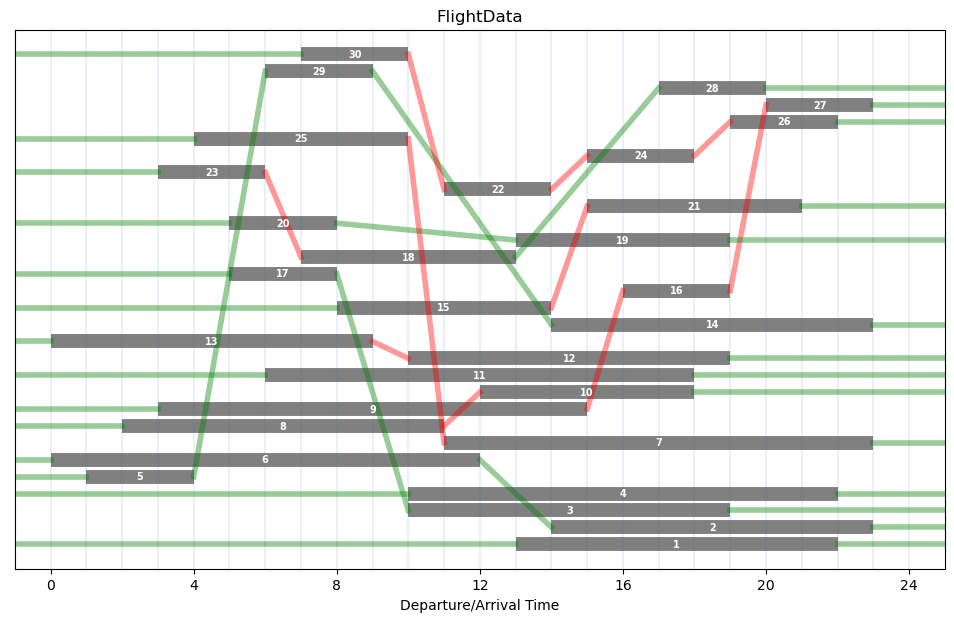

In [686]:
ax = draw_flights(FlightData)
for flight1, flight2 in flight_pairs:
    if m.x[flight1, flight2]() == 1:
        arr = FlightData.loc[flight1, "Arrival"]
        dep = FlightData.loc[flight2, "Departure"]
        c = 'r' if dep - arr <= min_time else 'g'
        ax.plot([arr, dep], [flight1, flight2], color=c, lw=4, alpha=0.4)

for flight in FlightData.index:
    if m.p[flight]() == 1:
        dep = FlightData.loc[flight, "Departure"]
        ax.plot([-1, dep], [flight]*2, 'g', lw=4, alpha=0.4)
    if m.q[flight]() == 1:
        arr = FlightData.loc[flight, "Arrival"]
        ax.plot([arr, 25], [flight]*2, 'g', lw=4, alpha=0.4)

## Allocate Aircraft to Flights

In [671]:
n = 0
FlightSchedule = FlightData.copy()

for f in FlightData.index:
    if m.p[f]() == 1:
        n += 1
        FlightSchedule.loc[f, "Aircraft"] = f"{n:2d}"
        while m.q[f]() != 1:
            for g in out_nodes[f]:
                if m.x[f, g]() == 1:
                    break
            FlightSchedule.loc[g, "Aircraft"] = f"{n:2d}"
            f = g

FlightSchedule = FlightSchedule[["Aircraft", "Departure", "Arrival"]]
FlightSchedule = FlightSchedule.sort_values(["Aircraft", "Departure"])
FlightSchedule["Flight"] = FlightSchedule.index
ind = pd.MultiIndex.from_frame(FlightSchedule[["Aircraft", "Flight"]])
FlightSchedule.index = ind
FlightSchedule = FlightSchedule[["Departure", "Arrival"]]
FlightSchedule

Departure  Arrival
Aircraft Flight                    
 1       1              13       22
 2       4              10       22
 3       5               1        4
         29              6        9
         14             14       23
 4       6               0       12
         2              14       23
 5       8               2       11
         10             12       18
 6       9               3       15
         16             16       19
         27             20       23
 7       11              6       18
 8       13              0        9
         12             10       19
 9       15              8       14
         21             15       21
10       17              5        8
         3              10       19
11       20              5        8
         19             13       19
12       23              3        6
         18              7       13
         28             17       20
13       25              4       10
         7              11       23
14       30              7       10
         22             11       14
         24             15       18
         26             19       22

In [655]:
FS = FlightSchedule.sort_values(["Aircraft", "Departure"])
ind = pd.MultiIndex(FS[["Aircraft"]

SyntaxError: unexpected EOF while parsing (405130420.py, line 2)

## Reformulation the fleet assignment as a network problem

The fleet assignment problem can be formulated and solved as a MILP. The idea of the MILP formulation is that for each aircraft to construct a feasible path in a graph where the flights are nodes with indices $1, \ldots, F$, and there is one source node $0$ and a sink node $F + 1$ such that only arcs can be used between nodes that can be operated after each other. Denote the set of flight indices by $\mathcal{F} = \left\{ 1, \ldots, F \right\}$, and the set of aircraft indices as $\mathcal{M} = \{ 1, \ldots, M\} $.

The set of arcs $\mathcal{A} \subseteq \mathcal{F} \cup \{0\} \times \mathcal{F} \cup \{F+1\}$ that can be used by each aircraft is then:

$$
\mathcal{A} = \{ a = (f_1, f_2): \text{arrival of } f_1 \text{at least 1h departure of } f_2, \ f_1, f_2 \in \mathcal{F} \} \cup \{ a = (0, f), \ f \in \mathcal{F} \} \cup \{ a = (f, F+1), \ f \in \mathcal{F} \},
$$

where $0$ and $F + 1$ play the role of dummy flights/nodes.

In this context, our decision variables shall be $x_{a, i} \in \{0, 1\}$, $a \in \mathcal{A}$, $i \in \mathcal{M}$ indicating whether the pair of flights $(f_1, f_2) = a$ is operated by aircraft $i$. Furthermore, we use the binary variables $y_i \in \{0, 1\}$, for $i \in \mathcal{M}$, to check whether a given aircraft $i$ is used or not. The corresponding MILP is then:

\begin{align}
    \min\limits_{x_{a, i}, y_i} \quad & \sum\limits_{i \in \mathcal{M}} y_i \label{eq:71a}\tag{a}\\
    \text{s.t.} \quad 
    & \sum\limits_{g \in \mathcal{F} \cup \{ 0, F+1\} ~:~ a = (g, f) \in \mathcal{A}} x_{a, i} = \sum\limits_{h \in \mathcal{F} \cup \{ 0, F+1\} ~:~ a' = (f, h) \in \mathcal{A}} x_{a', i} & \forall \, f \in \mathcal{F}, \ \forall \, i \in \mathcal{M} \label{eq:71b}\tag{b}\\
    & \sum\limits_{i \in \mathcal{M}} \sum\limits_{g \in \mathcal{F} \cup \{ 0, F+1\} ~:~ a = (g, f) \in \mathcal{A}} x_{a, i} = 1 & \forall \, f \in \mathcal{F} \label{eq:71c}\tag{c}\\
    & \sum\limits_{f \in \mathcal{F} \cup \{ 0, F+1\} ~:~ a = (0, f) \in \mathcal{A}} x_{a, i} \leq 1 & \forall \, i \in \mathcal{M} \label{eq:71d}\tag{d}\\
    & x_{(f, 0), i} \leq y_i & \forall \, f \in \mathcal{F}, \ \forall \, i \in \mathcal{M} \label{eq:71e}\tag{e}\\
    & y_i \leq y_{i - 1} & \forall \, i \in \mathcal{M}: \ i > 0 \label{eq:71f}\tag{f}\\
    & x_{a, i} \in \{0,1\} & \forall \, a \in \mathcal{A}, i \in \mathcal{M}\\
    & y_i \in \{0,1\} & \forall \, i \in \mathcal{M} 
\end{align}

where
- the objective function (\ref{eq:71a}) aims to minimize the number of used airplanes;
- constraint (\ref{eq:71b}) enforces that for a given real flight the number of used incoming arcs with airplane $i$ must be equal to the number of outgoing arcs with this airplane;
- constraint (\ref{eq:71c}) ensures that  each flight is operated by exactly one aircraft;
- constraint (\ref{eq:71d}) enforces that each airplane serves at most one path;
- constraint (\ref{eq:71e}) ensures that if at least one arc $(f, 0)$ is used using a given airplane, then this airplane is used;
- \eqref{eq:71f} is a symmetry-breaking constraint, which makes sure that we only use airplanes that come first in the aircraft set.


In [443]:
def flight_network(FlightData):
    
    # create a list of pairs of potentially subsequent flights
    flight_pairs = []

    for flight1 in FlightData.index:
        for flight2 in FlightData.index:
            if FlightData.loc[flight1, "Arrival"] < FlightData.loc[flight2, "Departure"]:
                flight_pairs.append((flight1, flight2))

    nb_flight_pairs = len(flight_pairs)

    pair_riskiness = {pair: 1 if FlightData.loc[pair[0], "Arrival"] + 1 == FlightData.loc[pair[1], "Departure"] else 0 for pair in flight_pairs}

    # create a dictionary of a pair of flights being risky or not
    dummy_node_index = max(FlightData.index) + 1
    start_pairs = []
    end_pairs = []
    
    for flight1 in FlightData.index:
        
        # dummy incoming node
        flight_pairs.append((dummy_node_index, flight1))
        start_pairs.append((dummy_node_index, flight1))
        pair_riskiness[(dummy_node_index, flight1)] = 0
        dummy_node_index += 1

        # dummy outgoing node
        flight_pairs.append((flight1, dummy_node_index))
        end_pairs.append((flight1, dummy_node_index))
        pair_riskiness[(flight1, dummy_node_index)] = 0
        dummy_node_index += 1
        
    return flight_pairs, pair_riskiness, start_pairs, end_pairs

def fleet_assignment(FlightData, flight_pairs, pair_riskiness, start_pairs, end_pairs):
    
    m = pyo.ConcreteModel("Fleet Assignment")
    max_planes = FlightData.shape[0]
    
    m.A = pyo.Set(initialize=list(range(max_planes)))
    m.F = pyo.Set(initialize=FlightData.index)
    m.P = pyo.Set(initialize=pair_riskiness.keys())
    m.x = pyo.Var(m.A, m.P, domain=pyo.Binary)
    m.y = pyo.Var(m.A, domain=pyo.Binary)
          
    # constraint: balance equations for all flights and planes
    @m.Constraint(m.A, m.F)
    def balance(m, aircraft, flight):
        return pyo.quicksum(m.x[aircraft, pair] for pair in pair_riskiness if pair[1] == flight) == pyo.quicksum(m.x[aircraft, pair] for pair in pair_riskiness if pair[0] == flight)

    # each flight assigned to exactly one aircraft
    @m.Constraint(m.F)
    def flightcovered(m, flight):
        return pyo.quicksum(m.x[aircraft, pair] for aircraft in m.A for pair in pair_riskiness if pair[1] == flight) == 1

    # each aircraft operates only one route
    @m.Constraint(m.A)
    def aircraftstarts(m, aircraft):
        return pyo.quicksum(m.x[aircraft, pair] for pair in start_pairs) <= 1
    
    @m.Constraint(m.A)
    def aircraftends(m, aircraft):
        return pyo.quicksum(m.x[aircraft, pair] for pair in end_pairs) <= 1

    # if aircraft serves at least one pair then it is considered used
    @m.Constraint(m.A, m.P)
    def aircraftisused(m, aircraft, pair0, pair1):
        return m.x[aircraft, (pair0, pair1)] <= m.y[aircraft]

    # symmetry breaking constraint
    @m.Constraint(m.A)
    def symmetrybreaking(m, aircraft):
        if aircraft > 0:
            return m.y[aircraft] <= m.y[aircraft - 1]
        else:
            return pyo.Constraint.Skip
    
    @m.Expression()
    def usedplanes(m):
        return pyo.quicksum(m.y[aircraft] for aircraft in m.A)

    @m.Objective(sense=pyo.minimize)
    def objective(m):
        return m.usedplanes

    m.solver = pyo.SolverFactory("gurobi")
    m.solver.solve(m)
    
    return m

def visualize(m, FlightData, name, seed = 0):
    
    N_flights = len(FlightData)
    FlightData["Aircraft"] = -1
    FlightData["Aircraft"].astype('int64')

    for aircraft in m.A:
        if m.y[aircraft]() > 0:
            flights = []
            for pair in flight_pairs:
                if m.x[aircraft, pair]() > 0:
                    if pair[0] < N_flights:
                        flights.append(pair[0])
                    if pair[1] < N_flights:
                        flights.append(pair[1])

            for flight in set(flights):
                FlightData.loc[flight, "Aircraft"] = aircraft
            
    JOBS = sorted(list(FlightData.index))
    AIRCRAFTS = sorted(list(FlightData['Aircraft'].unique()))
    makespan = FlightData['Arrival'].max()
    nb_aircraft = FlightData["Aircraft"].max() + 1
    
    bar_style = {'alpha':1.0, 'lw':25, 'solid_capstyle':'butt'}
    text_style = {'color':'white', 'weight':'bold', 'ha':'center', 'va':'center'}
    fig, ax = plt.subplots(figsize = (FlightData["Arrival"].max(), nb_aircraft / 2))
    
    for flight in FlightData.index:
        xs = FlightData.loc[flight, 'Departure']
        xf = FlightData.loc[flight, 'Arrival']
        jdx = FlightData.loc[flight, "Aircraft"]
        ax.plot([xs, xf], [jdx]*2, c = 'grey', **bar_style)
        ax.text((xs + xf)/2, jdx, str(flight), **text_style)
    
    ax.set_xlabel("Time (hours)")
    ax.set_ylabel("Plane number")
    ax.set_yticks(range(0, nb_aircraft))
    ax.set_xticks(np.arange(0, 25, 3))
    fig.tight_layout()
    plt.savefig(name + "_seed=" + str(seed) + ".pdf")
    plt.show()
    
    return None

flight_pairs, pair_riskiness, start_pairs, end_pairs = flight_network(FlightData)
m = fleet_assignment(FlightData, flight_pairs, pair_riskiness, start_pairs, end_pairs)
print(f'The optimal solution for this instance of the fleet assignment uses a total of {pyo.value(m.objective):.0f} planes.\n')
total_riskiness = sum([pair_riskiness[pair] * m.x[aircraft, pair]() for aircraft in m.A for pair in pair_riskiness])
print(f'The number of risky pairs (back-to-back flights operated by the same airplane with exactly 1h between them) in this solution is equal to {total_riskiness:.0f}.\n')
visualize(m, FlightData, "optimalschedule", seed)

ERROR: Solver (gurobi) returned non-zero return code (1)
ERROR: Solver log: Set parameter Username Traceback (most recent call last):
      File "<stdin>", line 5, in <module> File
      "/Users/jeff/opt/anaconda3/lib/python3.9/site-
      packages/pyomo/solvers/plugins/solvers/GUROBI_RUN.py", line 61, in
      gurobi_run
        model = read(model_file)
      File "src/gurobipy/gurobi.pxi", line 3575, in gurobipy.read File
      "src/gurobipy/gurobi.pxi", line 84, in gurobipy.gurobi.read File
      "src/gurobipy/gurobi.pxi", line 32, in gurobipy.gurobi._getdefaultenv
      File "src/gurobipy/env.pxi", line 62, in gurobipy.Env.__init__
    gurobipy.GurobiError: License expired 2022-04-28


ApplicationError: Solver (gurobi) did not exit normally

## Reducing riskiness of the schedule

We will now to keep the maximum number of flights at the optimal level, but try to minimize their riskiness. To do so, we define a slightly different MILP that takes the minimum number of planes `nplanes` in input and has the total number of risky pairs as objective function.


In [ ]:
def fleet_assignment_minimum_risk(FlightData, flight_pairs, pair_riskiness, start_pairs, end_pairs, nplanes):
    
    m = pyo.ConcreteModel("Fleet Assignment with minimum risk")
    max_planes = FlightData.shape[0]
    
    m.A = pyo.Set(initialize=list(range(max_planes)))
    m.F = pyo.Set(initialize=FlightData.index)
    m.P = pyo.Set(initialize=pair_riskiness.keys())
    m.x = pyo.Var(m.A, m.P, domain=pyo.Binary)
    m.y = pyo.Var(m.A, domain=pyo.Binary)
          
    # constraint: balance equations for all flights and planes
    @m.Constraint(m.A, m.F)
    def balance(m, aircraft, flight):
        return pyo.quicksum(m.x[aircraft, pair] for pair in pair_riskiness if pair[1] == flight) == pyo.quicksum(m.x[aircraft, pair] for pair in pair_riskiness if pair[0] == flight)

    # each flight assigned to exactly one aircraft
    @m.Constraint(m.F)
    def flightcovered(m, flight):
        return pyo.quicksum(m.x[aircraft, pair] for aircraft in m.A for pair in pair_riskiness if pair[1] == flight) == 1

    # each aircraft operates only one route
    @m.Constraint(m.A)
    def aircraftstarts(m, aircraft):
        return pyo.quicksum(m.x[aircraft, pair] for pair in start_pairs) <= 1
    
    @m.Constraint(m.A)
    def aircraftends(m, aircraft):
        return pyo.quicksum(m.x[aircraft, pair] for pair in end_pairs) <= 1

    # if aircraft serves at least one pair then it is considered used
    @m.Constraint(m.A, m.P)
    def aircraftisused(m, aircraft, pair0, pair1):
        return m.x[aircraft, (pair0, pair1)] <= m.y[aircraft]

    # symmetry breaking constraint
    @m.Constraint(m.A)
    def symmetrybreaking(m, aircraft):
        if aircraft > 0:
            return m.y[aircraft] <= m.y[aircraft - 1]
        else:
            return pyo.Constraint.Skip
    
    # fixed maximum number of planes
    @m.Constraint()
    def usedplanes(m):
        return pyo.quicksum(m.y[aircraft] for aircraft in m.A) <= nplanes
    
    @m.Expression()
    def riskypairs(m):
        return pyo.quicksum(pair_riskiness[pair] * m.x[aircraft, pair] for aircraft in m.A for pair in pair_riskiness)
    
    # new objective function minimizing riskiness
    @m.Objective(sense=pyo.minimize)
    def riskobjective(m):
        return m.riskypairs
    
    m.solver = pyo.SolverFactory("gurobi")
    m.solver.solve(m)
    
    return m

# reobtain a feasible number of planes by solving the previous model
flight_pairs, pair_riskiness, start_pairs, end_pairs = flight_network(FlightData)
m1 = fleet_assignment(FlightData, flight_pairs, pair_riskiness, start_pairs, end_pairs)
nplanes = pyo.value(m1.objective)

m2 = fleet_assignment_minimum_risk(FlightData, flight_pairs, pair_riskiness, start_pairs, end_pairs, nplanes)
print(f'The optimal solution for this instance of the fleet assignment uses a total of {pyo.value(pyo.quicksum(m2.y[aircraft] for aircraft in m2.A)):.0f} planes.\n')
print(f'The number of risky pairs (back-to-back flights operated by the same airplane with exactly 1h between them) in this new solution is equal to {pyo.value(m2.riskobjective):.0f}.\n')
visualize(m2, FlightData, "optimalschedule_minrisk", seed)